### Introduction

You might have already tried to calculate the power spectrum using pacakges like `nbodykit`. But do you know what actually happened when you were running codes like `nbodykit.algorithms.fftpower.FFTPower(...)`? If not, no worries! Since that is exactly the goal of this notebook.

### Goal:
* Understand Fourier Transformations
* Learn to calculate Power Spectrum
* Learn to calculate Potential and Force-field
* Learn how to get from linear field to Zel'dovich

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../../../")

import sheet_unfolding.sim as sim

from matplotlib.colors import LogNorm

In [2]:
def get_kmesh(npix, L, real=False):
    """ construct a uniform mesh of kvectors (for usage with np.fft.fftn)

    Parameters:
    ----------
    npix : sequence of integer
        Number of pixels in each dimension
    L :  float
        Size of the domain (in real space) - typically the boxsize
    real : bool
        Set to true for usage with np.fft.rfftn

    Returns:
    ----------
    knd : (npix[0], npix[1], ..., len(npix)) array of k-vectors

    Example:
    ----------
    k = get_kmesh((128,128,128), 10., real=False)
    => (128,128,128,3) array
    """

    ndim = len(npix)

    L = np.ones_like(npix) * L

    k1d = []
    for i in range(0, ndim):
        if (i == ndim-1) & real:  # last dim can have different shape in real fft
            k1d.append(np.fft.fftfreq(npix[i])[0:(npix[i]//2)+1] * (2*np.pi * npix[i]) / L[i])
        else:
            k1d.append(np.fft.fftfreq(npix[i]) * (2*np.pi * npix[i]) / L[i])

    knd  = np.array(np.meshgrid(*k1d, indexing='ij')).astype("f4")
    knd  = np.rollaxis(knd, 0, ndim+1)  # bring into shape [npix,npix,...,ndim]

    return knd

# Calculate the Power Spectrum


\begin{align}
  P(k) = \langle |\delta(|\vec{k}|)|^2 \rangle
\end{align}

\begin{align}
  \vec{k}_{i}, \delta_{k,i}
\end{align}

and the dimensionless one

\begin{align}
  D(k) = P(k) k^2 / (2 \pi)
\end{align}

(note that this relation (2D) is different in 3 dimensions)

To get the correct normalisation you will need to consider that the discrete Fourier transform (DFT) uses a different normalisation. To convert them you need

\begin{align}
  \delta_k = \delta_{k, DFT} \frac{\sqrt{L}^d}{N^d}
\end{align}
where $d = 2$ is the dimension

for the linear spectrum, you can use sim.ic.power_eisenstein_smoothed_2d, but you will have to renormalize it correctly (with sim.ic.get_sigmaR)

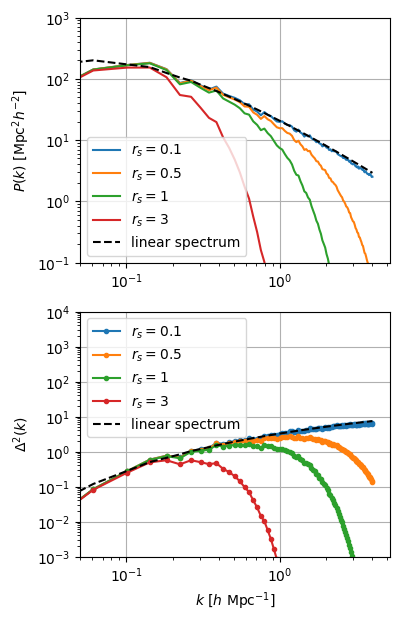

In [8]:
L = 400.

bins = np.linspace(0., 512*np.pi/L,100)
ki = 0.5*(bins[1:] + bins[:-1])

fig, axs = plt.subplots(2,1, figsize=(4,7))

for rs in (0.1, 0.5,1., 3.):
    myic = sim.ic.IC2DCosmo(512, L=L, rs=rs, Omega_m=1.)
    delta = myic.get_delta(a=1.)
    
    deltak =  np.fft.fft2(delta) / np.prod(delta.shape) * L
    
    kvec = get_kmesh((512,512), L)
    kabs = np.sqrt(np.sum(kvec**2, axis=-1))
    
    # Fill in code to calculate and plot power spectrum here: 
    # You'll need to average modes in each k-bin <---
    
    sum_deltak2,b = np.histogram(kabs, bins=bins, weights=np.abs(deltak)**2)
    N,b = np.histogram(kabs, bins=bins)
    pk = sum_deltak2 / N
    axs[0].loglog(ki, pk, label=r"$r_s = %g$" % rs)    
    axs[1].loglog(ki, pk * ki**2 / (2.*np.pi), label=r"$r_s = %g$" % rs, marker=".")
    
    # --->
    
norm = 0.8/sim.ic.get_sigmaR(8.)
axs[0].loglog(ki, norm**2*sim.ic.power_eisenstein_smoothed_2d(ki, dimless=False), ls="dashed", color="black", label="linear spectrum")
axs[1].loglog(ki, norm**2*sim.ic.power_eisenstein_smoothed_2d(ki, dimless=True), ls="dashed", color="black", label="linear spectrum")

axs[0].set_ylim(1e-1,1e3)
axs[1].set_ylim(1e-3,1e4)

for ax in axs:
    ax.grid()
    ax.legend()
    ax.set_xlim(5e-2, None)
axs[1].set_xlabel(r"$k$ [$h$ Mpc$^{-1}$]")
axs[0].set_ylabel(r"$P(k)$ [Mpc$^{2} h^{-2}$]")
axs[1].set_ylabel(r"$\Delta^2 (k)$")

plt.savefig("img/power_spectrum.png", bbox_inches="tight")

# Calculating the Potential
## Poisson's equation:
\begin{align}
   \nabla^2 \phi = 4 \pi G \delta \\
            \vec{a} = - \nabla \phi
\end{align}
in Fourier Space
\begin{align}
   \phi_k = - \frac{4 \pi G \delta_k}{k^2} \\
            \vec{a_k} = - i \vec{k} \phi_k
\end{align}

that means I can calculate $\phi$ and $a$ in real space by doing:
\begin{align}
   \phi = -4 \pi G \cdot \rm{IFFT}\left(\frac{\rm{FFT}(\delta)}{k^2}\right)
\end{align}

## Finite differences:
$\begin{align}
   f'(x) \approx \frac{f(x+h) - f(x-h)}{2 h}
\end{align}$


## Task:
* Calculate Potential Field in real space
* Calculate Acceleration Field (just the x-component) in real space
    - through Fourier Space
    - through finite differences on $\phi$

## Some Notes:
Just use $r_s = 0.1$ for this task. Assume $G=1$. You can set phi_k[0,0] explicitly to 0 to avoid problems with zero divisions. IFFT will return complex numbers with complex part = 0, but you can just cast them to real ones with np.real. Because of the numpy broadcasting rules (https://numpy.org/doc/stable/user/basics.broadcasting.html) you may have to do something like this to multiply a field by a vector field: phik[...,np.newaxis] * kvec

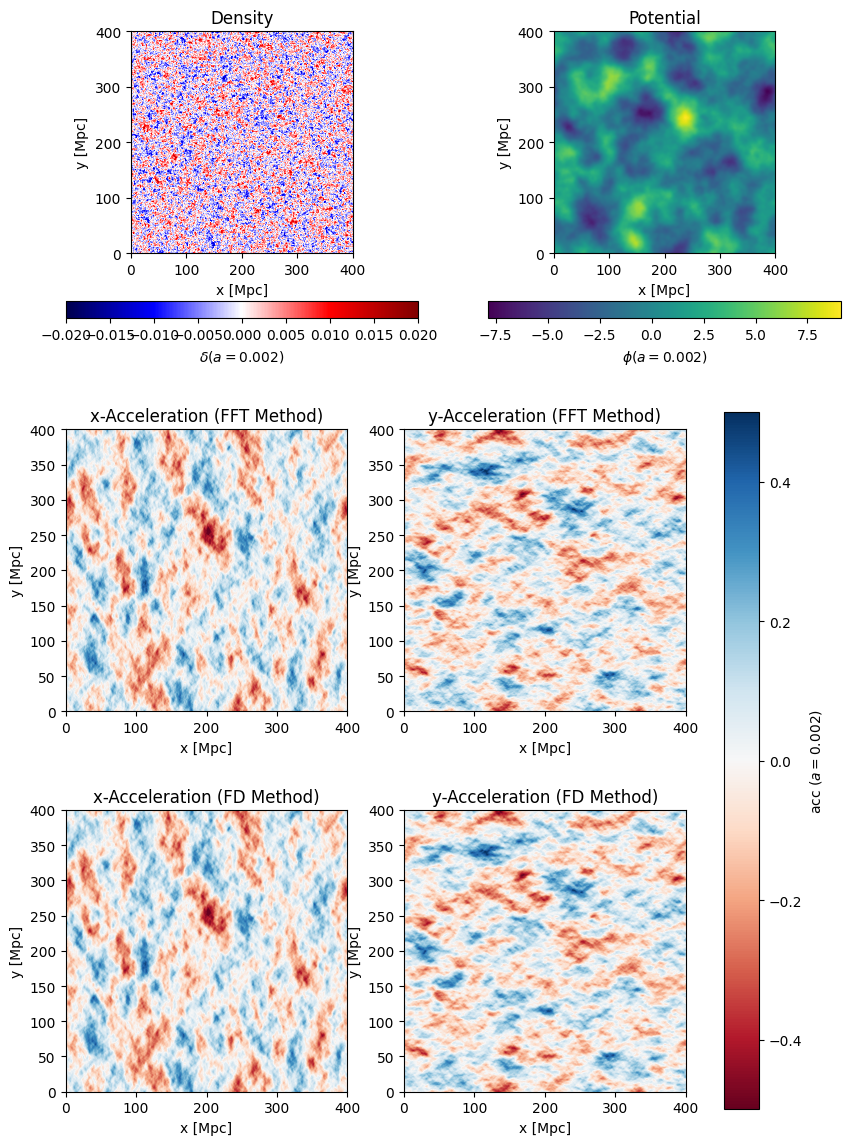

In [6]:
G = 1
myic = sim.ic.IC2DCosmo(512, L=L, rs=0.1, vec3d=True, Omega_m=1.)
delta = myic.get_delta(a=0.002)

# Fill in code here
delta_k = np.fft.fft2(delta)

phi_k = - 4 * np.pi * G * delta_k / np.clip(kabs, 1e-20, None)**2
phi_k[0,0] = 0.
phi = np.real(np.fft.ifft2(phi_k))

acc_k = -1j * kvec * phi_k[...,np.newaxis]
acc = np.real(np.fft.ifft2(acc_k, axes=(0,1)))

accx_finitediff = -((np.roll(phi, -1, axis=0) - np.roll(phi, 1, axis=0)) / (2.*(L/512.)))
accy_finitediff = -((np.roll(phi, -1, axis=1) - np.roll(phi, 1, axis=1)) / (2.*(L/512.)))

fig, axs = plt.subplots(3, 2, figsize=(10,14))

im = axs[0,0].imshow(delta.T, origin="lower", cmap="seismic", vmin=-0.02, vmax=0.02, extent=[0,L,0,L])
plt.colorbar(im, ax=axs[0,0], orientation="horizontal", label=r"$\delta (a = 0.002)$")
axs[0,0].set_title("Density")

im = axs[0,1].imshow(phi.T, origin="lower", cmap="viridis", extent=[0,L,0,L])
plt.colorbar(im, ax=axs[0,1], orientation="horizontal", label=r"$\phi (a = 0.002)$")
axs[0,1].set_title("Potential")

im = axs[1,0].imshow(acc[...,0].T, origin="lower", cmap="RdBu", vmin=-0.5, vmax=0.5, extent=[0,L,0,L])
im = axs[1,1].imshow(acc[...,1].T, origin="lower", cmap="RdBu", vmin=-0.5, vmax=0.5, extent=[0,L,0,L])
axs[1,0].set_title(r"x-Acceleration (FFT Method)")
axs[1,1].set_title(r"y-Acceleration (FFT Method)")

im = axs[2,0].imshow(accx_finitediff.T, origin="lower", cmap="RdBu", vmin=-0.5, vmax=0.5, extent=[0,L,0,L])
im = axs[2,1].imshow(accy_finitediff.T, origin="lower", cmap="RdBu", vmin=-0.5, vmax=0.5, extent=[0,L,0,L])
plt.colorbar(im, ax=axs[1:3,:], orientation="vertical", label=r"acc $(a = 0.002)$")
axs[2,0].set_title(r"x-Acceleration (FD Method)")
axs[2,1].set_title(r"y-Acceleration (FD Method)")

for ax in axs.flat:
    ax.set_xlabel("x [Mpc]")
    ax.set_ylabel("y [Mpc]")
    
plt.savefig("img/force_calculation.png", bbox_inches="tight")